In [1]:
import yfinance as yf
from datetime import datetime, date, timedelta
import ta
from sklearn.preprocessing import StandardScaler
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, A2C
from sb3_contrib import RecurrentPPO
import optuna
import matplotlib.pyplot as plt
import gym_anytrading
from gym_anytrading.envs import StocksEnv,Actions,Positions
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import pickle

# 1. Load Data

In [2]:
#Change these variables if necessary
window_size = 5
start_date = '2020-01-01' 
today = datetime.today().date()
end_date = today.strftime("%Y-%m-%d") #today is the end
ticker = "NVDA"

In [3]:
#SEED = 99
#np.random.seed(SEED)
#random.seed(SEED))

stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d')

df = stock_data.reset_index()#[['Date','Close']]

df.sort_values(by=['Date'], inplace=True)

data = df.copy()

# Calculate Simple Moving Average (SMA)
data['sma'] = ta.trend.sma_indicator(data['Close'], window=10)

# Calculate Exponential Moving Average (EMA)
data['ema'] = ta.trend.ema_indicator(data['Close'], window=10)

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(data['Close'])
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()
data['macd_diff'] = macd.macd_diff()

# Calculate Stochastic Oscillator
stochastic_osc = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=10, smooth_window=3)
data['stoch'] = stochastic_osc.stoch()
data['stoch'].replace([-float('inf'), float('inf')], np.nan, inplace=True)
data['stoch_signal'] = stochastic_osc.stoch_signal()

# Calculate Relative Strength Index (RSI)
data['rsi'] = ta.momentum.rsi(data['Close'], window=10)

# Calculate Average True Range (ATR)
data['atr'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=10)

# Calculate Accumulation Distribution Index (ADI)
data['adi'] = ta.volume.acc_dist_index(data['High'], data['Low'], data['Close'], data['Volume'])
data['adi'].replace([np.inf, -np.inf], 0, inplace=True)

# Calculate Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
data['bollinger_hband'] = bollinger.bollinger_hband()
data['bollinger_lband'] = bollinger.bollinger_lband()
data['bollinger_mavg'] = bollinger.bollinger_mavg()

#Commodity Channel Index (CCI)
data['cci'] = ta.trend.cci(data['High'], data['Low'], data['Close'], window=20)

# Aroon Indicator
aroon = ta.trend.AroonIndicator(high=data['High'], low=data['Low'], window=25)
data['aroon_up'] = aroon.aroon_up()
data['aroon_down'] = aroon.aroon_down()

# Williams %R
data['williams_r'] = ta.momentum.williams_r(data['High'], data['Low'], data['Close'], lbp=10)
data['williams_r'].replace([-float('inf'), float('inf')], np.nan, inplace=True)


# Money Flow Index (MFI)
data['mfi'] = ta.volume.money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'], window=10)

# Rate of Change (ROC)
data['roc'] = ta.momentum.roc(data['Close'], window=10)

# Chaikin A/D Line
data['chaikin_ad'] = ta.volume.ChaikinMoneyFlowIndicator(data['High'], data['Low'], data['Close'], data['Volume'], window=20).chaikin_money_flow()

# On-Balance Volume (OBV)
data['obv'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])


df = data.dropna() ## <- Might need to change this if more variables are added
df.drop(['Dividends','Stock Splits'],axis=1, inplace=True)


/var/folders/yf/0wv1c8p96x15nmycpl2csp9m0000gn/T/ipykernel_95122/1715772872.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['stoch'].replace([-float('inf'), float('inf')], np.nan, inplace=True)
/var/folders/yf/0wv1c8p96x15nmycpl2csp9m0000gn/T/ipykernel_95122/1715772872.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

In [ ]:
train_df = df[df['Date']<'2023-12-01']
val_df = df[(df['Date']>='2023-12-01') & (df['Date']<'2024-12-01')]
test_df = df[df['Date']>='2024-12-01']

columns_to_scale = [col for col in df.columns if col not in ["Date"]]
scaler = StandardScaler()
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale]) 
val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

train_df.set_index('Date', inplace=True)
val_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

# 2. Customize Environment

In [4]:
class CustomStocksEnv(StocksEnv):
    def __init__(self, df, window_size, frame_bound, render_mode=None):
        super().__init__(df, window_size, frame_bound, render_mode)

        self.trade_fee_bid_percent = 0.001  # unit
        self.trade_fee_ask_percent = 0.001 
    
    def _process_data(self):
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
        signal_features = self.df.drop(['Close'],axis=1).to_numpy()[start:end]
    
        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff, signal_features))
    
        close_col_idx = self.df.columns.get_loc('Close')
        close_mean = scaler.mean_[close_col_idx]
        close_scale = scaler.scale_[close_col_idx]
        # invert scaling
        prices = prices * close_scale + close_mean
        
        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


# 3. PPO Reinforcement Learning

## a. Fine tuning 

In [5]:
def objective(trial: optuna.Trial):
    """
    Fine tuning using Bayesian Optimization from optuna
    """

    # --- Sample hyperparameters from ranges ---
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2,log=True)
    n_steps       = trial.suggest_int("n_steps", 128, 2048, step=128)
    gamma         = trial.suggest_float("gamma", 0.90, 0.99, step=0.01)
    ent_coef      = trial.suggest_float("ent_coef", 1e-8, 0.1, log=True)
    clip_range    = trial.suggest_float("clip_range", 0.1, 0.4, step=0.05)

    #Less important hyperparameters:
    batch_size       = trial.suggest_categorical("batch_size", [32,64])
    gae_lambda       = trial.suggest_float("gae_lambda", 0.8, 0.98)
    n_epochs       = trial.suggest_int("n_epochs", 5, 20)


    # --- Create the environment ---
    train_env = CustomStocksEnv(df=train_df, window_size=window_size, frame_bound=(window_size, len(train_df)))
    val_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
    val_env = Monitor(val_env)

    eval_callback_ft = EvalCallback(
        val_env,
        best_model_save_path='./logs/best_model_ft/',
        log_path='./logs/results_ft/',
        eval_freq=500,  # Evaluate every 500 timesteps.
        deterministic=True,
        render=False,
        verbose=0
    )
    
    # Build the PPO model
    model = PPO( 
        policy="MlpPolicy", 
        env=train_env, 
        verbose=0, 
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        gae_lambda=gae_lambda,
        gamma=gamma,
        n_epochs=n_epochs, 
        ent_coef=ent_coef,
        clip_range=clip_range
    )

    #Keep it short - 50,000 steps also make sense
    model.learn(total_timesteps=100_000, callback=eval_callback_ft)

    model = PPO.load("./logs/best_model_ft/best_model.zip")
    mean_reward, std_reward = evaluate_policy(model, val_env, n_eval_episodes=10, deterministic=False)

    # Cleanup the environments
    train_env.close()
    val_env.close()

    return mean_reward

def run_optimization():
    study = optuna.create_study(direction="maximize")  
    study.optimize(objective, n_trials=300)

    print("Best hyperparameters:", study.best_params)
    print("Best value (objective):", study.best_value)

    return study



In [6]:
#Run fine tuning
study = run_optimization()

with open("ppo_best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

[I 2025-02-03 05:09:22,595] A new study created in memory with name: no-name-bf851207-ec5a-40ac-83e2-fb7588b7a062
[I 2025-02-03 05:10:37,647] Trial 0 finished with value: 52.8174848 and parameters: {'learning_rate': 2.8120532392347434e-05, 'n_steps': 1024, 'gamma': 0.96, 'ent_coef': 1.863783370879267e-08, 'clip_range': 0.4, 'batch_size': 64, 'gae_lambda': 0.9560105707026503, 'n_epochs': 14}. Best is trial 0 with value: 52.8174848.
[I 2025-02-03 05:11:39,745] Trial 1 finished with value: 29.588680599999996 and parameters: {'learning_rate': 0.0007452181302411, 'n_steps': 1792, 'gamma': 0.97, 'ent_coef': 0.00012620637341360266, 'clip_range': 0.15000000000000002, 'batch_size': 64, 'gae_lambda': 0.8043218035307864, 'n_epochs': 9}. Best is trial 0 with value: 52.8174848.
[I 2025-02-03 05:13:09,236] Trial 2 finished with value: 66.06046220000002 and parameters: {'learning_rate': 0.0004959920369242631, 'n_steps': 512, 'gamma': 0.96, 'ent_coef': 0.00020215087835153707, 'clip_range': 0.4, 'batch

Best hyperparameters: {'learning_rate': 0.0007349336867716473, 'n_steps': 128, 'gamma': 0.99, 'ent_coef': 5.364021124191972e-05, 'clip_range': 0.4, 'batch_size': 32, 'gae_lambda': 0.8384513004766956, 'n_epochs': 17}
Best value (objective): 140.7981624


## b. Training final model

In [ ]:

#Train the final model
best_params = study.best_params


train_env = CustomStocksEnv(df=train_df, window_size=window_size, frame_bound=(window_size, len(train_df)))
val_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
val_env = Monitor(val_env)

eval_callback = EvalCallback(
        val_env,
        best_model_save_path='./logs/best_model/',
        log_path='./logs/results/',
        eval_freq=500,  # Evaluate every 500 timesteps.
        deterministic=True,
        render=False
    )

final_model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=best_params["learning_rate"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    ent_coef=best_params["ent_coef"],
    clip_range=best_params["clip_range"],
    batch_size=best_params["batch_size"],
    gae_lambda=best_params["gae_lambda"],
    n_epochs=best_params["n_epochs"],
    verbose=1,
)

final_model.learn(total_timesteps=500_000, callback=eval_callback)
final_model.save("ppo_stocks_model")

#Load best model
final_model = PPO.load("./logs/best_model/best_model.zip")


#val_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
mean_reward, std_reward = evaluate_policy(final_model, val_env, n_eval_episodes=20, deterministic=False)

print(f"Final model evaluation on validation set: Mean Reward = {mean_reward:.2f} ± {std_reward:.2f}")

train_env.close()
val_env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 5521 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 128  |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 2003       |
|    iterations           | 2          |
|    time_elapsed         | 0          |
|    total_timesteps      | 256        |
| train/                  |            |
|    approx_kl            | 0.06256106 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.656     |
|    explained_variance   | 0.237      |
|    learning_rate        | 0.000735   |
|    loss                 | -0.14      |
|    n_updates            | 17         |
|    policy_gradient_loss | -0.0653    |
|    value_loss           | 0.0205     |

## c. Prediction

Final info: {'total_reward': np.float32(5.1399765), 'total_profit': np.float32(1.0162286), 'position': <Positions.Short: 0>}


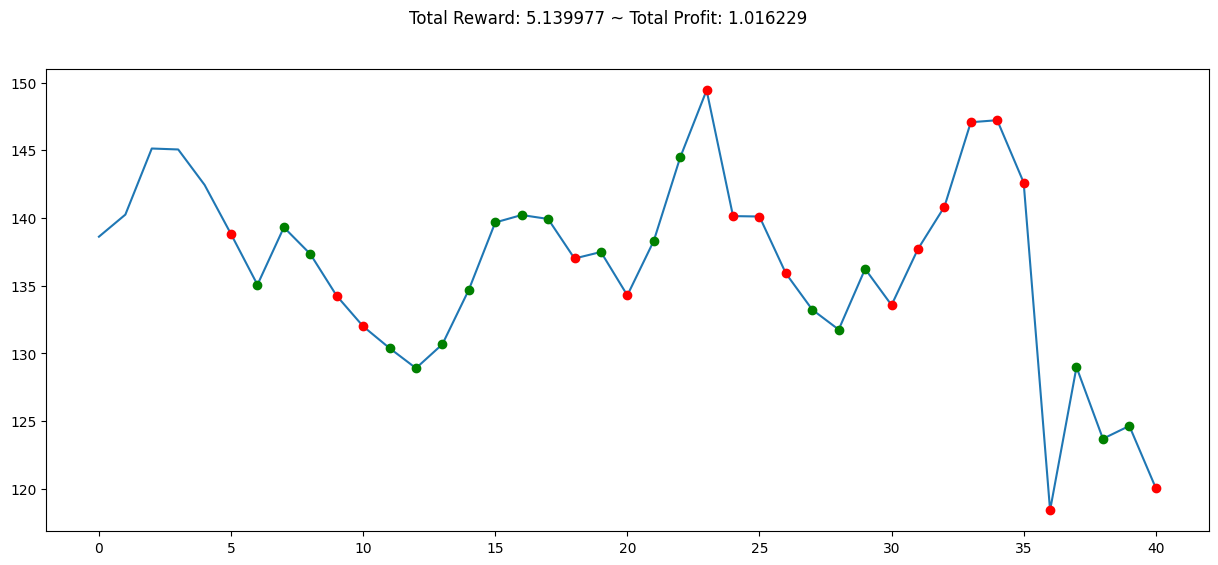

In [11]:
test_env = CustomStocksEnv(df=test_df, window_size=window_size, frame_bound=(window_size, len(test_df)))
final_model = PPO.load("./logs/best_model/best_model.zip")#load("ppo_stocks_model", env=test_env)

obs, info = test_env.reset()
rewards = []
while True:
    action, _states = final_model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

    #print(reward)
    #print(action)
    #print(info)
    #rewards.append(reward)
    if done:
        print("Final info:", info)
        break

# (Optional) Render the final trading history
plt.figure(figsize=(15, 6))
plt.cla()
test_env.unwrapped.render_all()
plt.show()

# Close the environment to free resources
test_env.close()

Final info: {'total_reward': np.float32(109.24083), 'total_profit': np.float32(3.4856975), 'position': <Positions.Short: 0>}


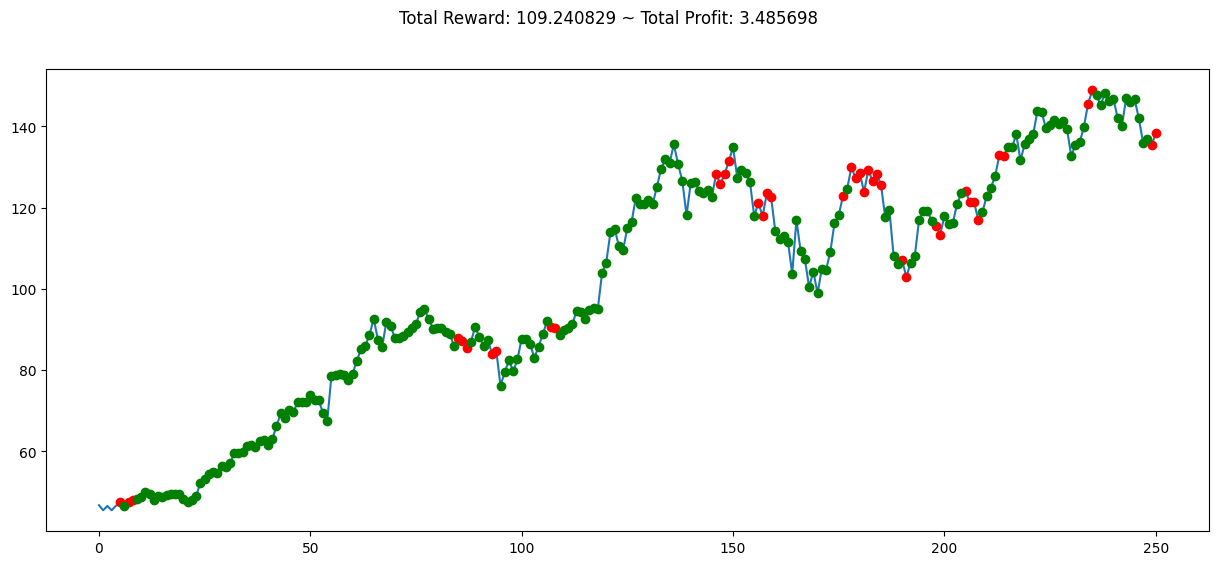

In [14]:
#Performance on train_df
test_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
final_model = PPO.load("./logs/best_model/best_model.zip")#load("ppo_stocks_model", env=test_env)

obs, info = test_env.reset()
rewards = []
while True:
    action, _states = final_model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    if done:
        print("Final info:", info)
        break

# (Optional) Render the final trading history
plt.figure(figsize=(15, 6))
plt.cla()
test_env.unwrapped.render_all()
plt.show()

# Close the environment to free resources
test_env.close()

# 4. RecurrentPPO Reinforcement Learning

Because RecurrentPPO is an extension of PPO, we can reused hyperparameters from PPO

## a. Fine tuning

In [12]:
with open("ppo_best_params.pkl", "rb") as f:
    ppo_best_params = pickle.load(f)

def recurrent_ppo_objective(trial: optuna.Trial):
    """
    Fine tuning using Bayesian Optimization from optuna
    """
    if ppo_best_params is not None:
        # Sample LSTM hyperparams
        n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 3)
        hidden_size  = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
        dropout      = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    
        # PPO hyperparams
        learning_rate = ppo_best_params['learning_rate']
        n_steps       = ppo_best_params['n_steps']
        gamma         = ppo_best_params['gamma']
        ent_coef      = ppo_best_params['ent_coef']
        clip_range    = ppo_best_params['clip_range']
        batch_size       = ppo_best_params['batch_size']
        gae_lambda       = ppo_best_params['gae_lambda']
        n_epochs       = ppo_best_params['n_epochs']
        
    else:
        # Sample LSTM hyperparams
        n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 3)
        hidden_size  = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
        dropout      = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    
        # PPO hyperparams
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2,log=True)
        n_steps       = trial.suggest_int("n_steps", 128, 2048, step=128)
        gamma         = trial.suggest_float("gamma", 0.90, 0.99, step=0.01)
        ent_coef      = trial.suggest_float("ent_coef", 1e-8, 0.1, log=True)
        clip_range    = trial.suggest_float("clip_range", 0.1, 0.4, step=0.05)
    
        #Less important hyperparameters:
        batch_size       = trial.suggest_categorical("batch_size", [32,64])
        gae_lambda       = trial.suggest_float("gae_lambda", 0.8, 0.98)
        n_epochs       = trial.suggest_int("n_epochs", 5, 20)


    # --- Create the environment ---
    train_env = CustomStocksEnv(df=train_df, window_size=window_size, frame_bound=(window_size, len(train_df)))
    val_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
    val_env = Monitor(val_env)

    eval_callback_ft = EvalCallback(
        val_env,
        best_model_save_path='./logs/best_model_ft_lstm/',
        log_path='./logs/results_ft/',
        eval_freq=500,  # Evaluate every 500 timesteps.
        deterministic=True,
        render=False,
        verbose=0
    )
    
    # Build policy_kwargs with a LSTM
    policy_kwargs = dict(
        #rnn_class=nn.GRU,
        n_lstm_layers=n_lstm_layers,
        lstm_hidden_size = hidden_size,
        lstm_kwargs=dict(
            dropout=dropout
        ),
        # after GRU, we add a small MLP
        net_arch=dict(pi=[64], vf=[64])
    )

    # Build the RecurrentPPO model
    model = RecurrentPPO( 
        policy="MlpLstmPolicy", 
        env=train_env, 
        verbose=0, 
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        gae_lambda=gae_lambda,
        gamma=gamma,
        n_epochs=n_epochs, 
        ent_coef=ent_coef,
        clip_range=clip_range,
        policy_kwargs=policy_kwargs,
    )


    #Keep it short - 50,000 steps also make sense
    model.learn(total_timesteps=100_000, callback=eval_callback_ft)

    model = RecurrentPPO.load("./logs/best_model_ft_lstm/best_model.zip")
    mean_reward, std_reward = evaluate_policy(model, val_env, n_eval_episodes=10, deterministic=False)

    # Cleanup the environments
    train_env.close()
    val_env.close()

    return mean_reward

def run_lstm_optimization():
    n_trials = 50 if ppo_best_params is not None else 100
    study = optuna.create_study(direction="maximize")  
    study.optimize(recurrent_ppo_objective, n_trials=n_trials)

    print("Best hyperparameters:", study.best_params)
    print("Best value (objective):", study.best_value)

    return study



In [ ]:
#Run fine tuning
lstm_study = run_lstm_optimization()

lstm_best_params = lstm_study.best_params

if ppo_best_params is not None:
    lstm_best_params.update(ppo_best_params)

with open("lstm_best_params.pkl", "wb") as f:
    pickle.dump(lstm_best_params, f)

## b. Training final model

In [ ]:
train_lstm_env = CustomStocksEnv(df=train_df, window_size=window_size, frame_bound=(window_size, len(train_df)))
val_lstm_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
val_lstm_env = Monitor(val_lstm_env)

lstm_eval_callback = EvalCallback(
        val_lstm_env,
        best_model_save_path='./logs/best_model_lstm/',
        log_path='./logs/results/',
        eval_freq=500,  # Evaluate every 500 timesteps.
        deterministic=True,
        render=False
    )

final_policy_kwargs = dict(
    n_lstm_layers=lstm_best_params["n_lstm_layers"],
    lstm_hidden_size = lstm_best_params["hidden_size"],
    lstm_kwargs=dict(
        dropout=lstm_best_params["dropout"]
    ),
    net_arch=dict(pi=[64], vf=[64])
)

final_lstm_model = RecurrentPPO(
    policy="MlpLstmPolicy",
    env=train_lstm_env,
    learning_rate=lstm_best_params["learning_rate"],
    n_steps=lstm_best_params["n_steps"],
    gamma=lstm_best_params["gamma"],
    ent_coef=lstm_best_params["ent_coef"],
    clip_range=lstm_best_params["clip_range"],
    batch_size=lstm_best_params["batch_size"],
    gae_lambda=lstm_best_params["gae_lambda"],
    n_epochs=lstm_best_params["n_epochs"],
    policy_kwargs=final_policy_kwargs,
    verbose=1
)


final_lstm_model.learn(total_timesteps=100_000, callback= lstm_eval_callback)
final_lstm_model.save("recurrent_ppo_stocks_model")

final_model = RecurrentPPO.load("./logs/best_model_lstm/best_model.zip")

#val_lstm_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
mean_reward, std_reward = evaluate_policy(final_lstm_model, val_lstm_env, n_eval_episodes=20, deterministic=False)

print(f"Final model evaluation on validation set: Mean Reward = {mean_reward:.2f} ± {std_reward:.2f}")

train_lstm_env.close()
val_lstm_env.close()

## c. Prediction

Final info: {'total_reward': np.float32(-1.3300095), 'total_profit': np.float32(0.9746087), 'position': <Positions.Short: 0>}


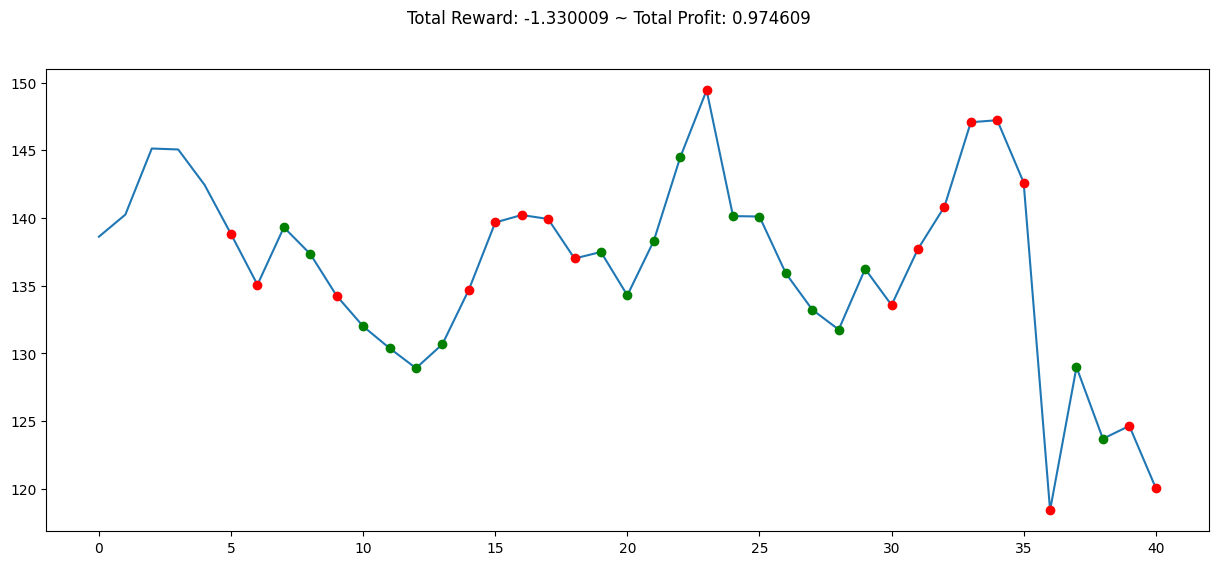

In [45]:
test_lstm_env = CustomStocksEnv(df=test_df, window_size=window_size, frame_bound=(window_size, len(test_df)))
final_lstm_model = RecurrentPPO.load("./logs/best_model_lstm/best_model.zip")#.load("recurrent_ppo_stocks_model", env=test_lstm_env)

obs, info = test_lstm_env.reset()
rewards = []
while True:
    action, _states = final_lstm_model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = test_lstm_env.step(action)
    done = terminated or truncated

    #print(reward)
    #print(action)
    #print(info)
    #rewards.append(reward)
    if done:
        print("Final info:", info)
        break


plt.figure(figsize=(15, 6))
plt.cla()
test_lstm_env.unwrapped.render_all()
plt.show()

test_lstm_env.close()


# 5. A2C Reinforcement Learning

## a. Fine tuning

In [5]:
def a2c_objective(trial: optuna.Trial):
    """
    Fine tuning using Bayesian Optimization from optuna
    """

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    # A2C typically uses smaller n_steps than PPO since it updates synchronously
    n_steps       = trial.suggest_int("n_steps", 5, 130, step=5)
    gamma         = trial.suggest_float("gamma", 0.90, 0.99, step=0.01)
    ent_coef      = trial.suggest_float("ent_coef", 1e-8, 0.1, log=True)
    gae_lambda    = trial.suggest_float("gae_lambda", 0.8, 0.98)
    # A2C-specific hyperparameters:
    vf_coef       = trial.suggest_float("vf_coef", 0.1, 1.0, step=0.1)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, step=0.1)


    # --- Create the environment ---
    train_env = CustomStocksEnv(df=train_df, window_size=window_size, frame_bound=(window_size, len(train_df)))
    val_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
    val_env = Monitor(val_env)

    eval_callback_ft = EvalCallback(
        val_env,
        best_model_save_path='./logs/best_model_ft_a2c/',
        log_path='./logs/results_ft_a2c/',
        eval_freq=500,  # Evaluate every 500 timesteps.
        deterministic=True,
        render=False,
        verbose=0
    )
    
    # Build the A2C model
    model = A2C(
        policy="MlpPolicy",
        env=train_env,
        verbose=0,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        gae_lambda=gae_lambda,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        max_grad_norm=max_grad_norm
    )

    #Keep it short - 50,000 steps also make sense
    model.learn(total_timesteps=100_000, callback=eval_callback_ft)

    model = PPO.load("./logs/best_model_ft_a2c/best_model.zip")
    mean_reward, std_reward = evaluate_policy(model, val_env, n_eval_episodes=10, deterministic=False)

    # Cleanup the environments
    train_env.close()
    val_env.close()

    return mean_reward

def run_a2c_optimization():
    study = optuna.create_study(direction="maximize")  
    study.optimize(a2c_objective, n_trials=300)

    print("Best hyperparameters:", study.best_params)
    print("Best value (objective):", study.best_value)

    return study



In [ ]:
#Run fine tuning
a2c_study = run_a2c_optimization()

with open("a2c_best_params.pkl", "wb") as f:
    pickle.dump(a2c_study.best_params, f)

## b. Training final model

In [ ]:
#Train the final model
a2c_best_params = a2c_study.best_params


train_a2c_env = CustomStocksEnv(df=train_df, window_size=window_size, frame_bound=(window_size, len(train_df)))
val_a2c_env = CustomStocksEnv(df=val_df, window_size=window_size, frame_bound=(window_size, len(val_df)))
val_a2c_env = Monitor(val_a2c_env)

eval_callback_a2c = EvalCallback(
        val_a2c_env,
        best_model_save_path='./logs/best_model_a2c/',
        log_path='./logs/results/',
        eval_freq=500,  # Evaluate every 500 timesteps.
        deterministic=True,
        render=False
    )



final_a2c_model = A2C(
        policy="MlpPolicy",
        env=train_a2c_env,
        verbose=1,
        learning_rate=a2c_best_params['learning_rate'],
        n_steps=a2c_best_params['n_steps'],
        gamma=a2c_best_params['gamma'],
        gae_lambda=a2c_best_params['gae_lambda'],
        ent_coef=a2c_best_params['ent_coef'],
        vf_coef=a2c_best_params['vf_coef'],
        max_grad_norm=a2c_best_params['max_grad_norm']
    )


final_a2c_model.learn(total_timesteps=500_000, callback=eval_callback_a2c)
final_a2c_model.save("a2c_stocks_model")

#Load best model
final_a2c_model = A2C.load("./logs/best_model_a2c/best_model.zip")


mean_reward, std_reward = evaluate_policy(final_a2c_model, val_a2c_env, n_eval_episodes=20, deterministic=False)

print(f"Final model evaluation on validation set: Mean Reward = {mean_reward:.2f} ± {std_reward:.2f}")

train_env.close()
val_env.close()

## c. Prediction

Final info: {'total_reward': np.float32(-5.0999985), 'total_profit': np.float32(0.94984543), 'position': <Positions.Short: 0>}


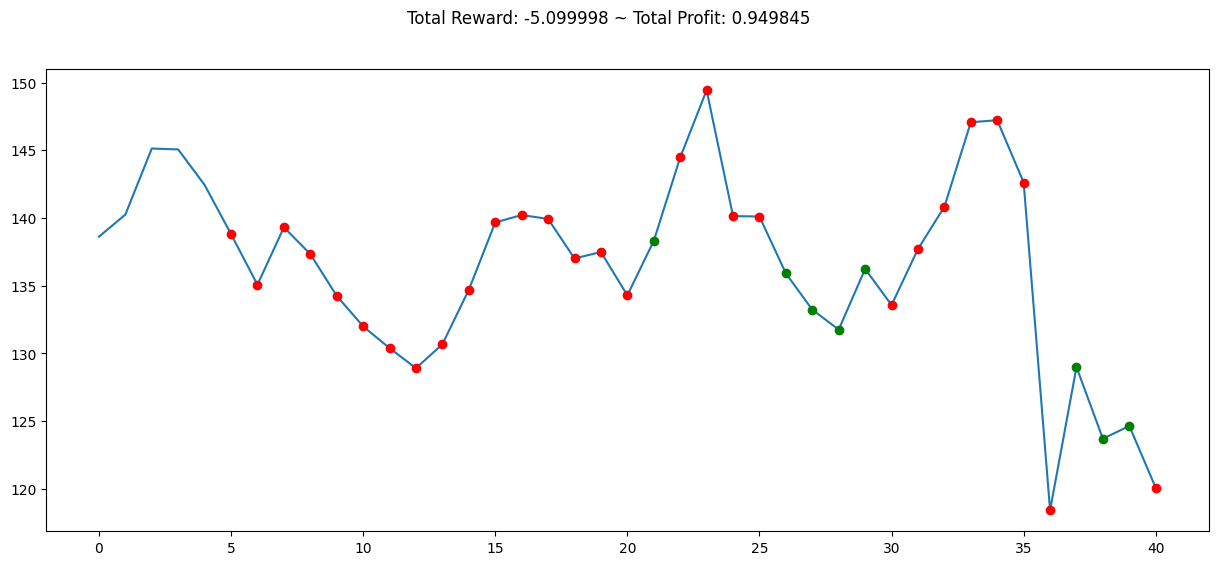

In [68]:
test_a2c_env = CustomStocksEnv(df=test_df, window_size=window_size, frame_bound=(window_size, len(test_df)))
final_a2c_model = PPO.load("./logs/best_model_a2c/best_model.zip")#load("a2c_stocks_model", env=test_a2c_env)

obs, info = test_a2c_env.reset()
while True:
    action, _states = final_a2c_model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = test_a2c_env.step(action)
    done = terminated or truncated

    if done:
        print("Final info:", info)
        break

plt.figure(figsize=(15, 6))
plt.cla()
test_a2c_env.unwrapped.render_all()
plt.show()

# Close the environment to free resources
test_a2c_env.close()